EDA - New York Airbnb data

In [272]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
from pickle import dump
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

1. DATA COLLECTION

In [273]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv"
destination_path = "../data/raw/AB_NYC_2019.csv"

df = pd.read_csv(url)
df.to_csv(destination_path, index=False)

print("df is in:", destination_path)

df is in: ../data/raw/AB_NYC_2019.csv


In [274]:
df = pd.read_csv("../data/raw/AB_NYC_2019.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


2. EXPLORE & CLEAN DATA

In [275]:
# 2.1: DIMENSIONS ➞ (rows, columns)
df.shape

(48895, 16)

In [276]:
# 2.2: DATA TYPES & NON-NULL VALUES
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [277]:
df.isna().sum()[df.isna().sum()>0]

name                    16
host_name               21
last_review          10052
reviews_per_month    10052
dtype: int64

Observations:

From the previous info. we can see we have NA records:
- 'name': 16 Nulls → Considering this is the 'property name' we will fill NAs with 'fillna()' and later analyze if this has any impact when renting the properties.
- 'host_name': 21 Nulls → Considering each 'host_name' has its own 'host_is', we will check if they have other properties where the name appears. 
- 'last_review' and 'reviews_per_month': 10052 Nulls → They might be recently added properties which have not been rented yet.

Data types:
Numerical data: 10 columns
Categorical data: 6 columns

In [278]:
# 2.3: FIND & DELETE DUPLICATES
print(f"Nº of duplicated 'id' records is: {df['id'].duplicated().sum()}")

Nº of duplicated 'id' records is: 0


Observations:

Nº of 'id' duplicated records = 0 → all records should be unique.

In [279]:
# 2.4: DELETE IRRELEVANT INFO. & DEAL WITH NA VALUES
df.drop(columns=["id", "name", "host_name", "last_review", "latitude", "longitude"], axis = 1, inplace = True)
df.head()

,host_id,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2787,Brooklyn,Kensington,Private room,149,1,9,0.21,6,365
1,2845,Manhattan,Midtown,Entire home/apt,225,1,45,0.38,2,355
2,4632,Manhattan,Harlem,Private room,150,3,0,NaN,1,365
3,4869,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,4.64,1,194
4,7192,Manhattan,East Harlem,Entire home/apt,80,10,9,0.10,1,0


In [280]:
df.isna().sum().sort_values(ascending=False) / len(df)

reviews_per_month                 0.205583
host_id                           0.000000
neighbourhood_group               0.000000
neighbourhood                     0.000000
price                             0.000000
room_type                         0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
calculated_host_listings_count    0.000000
availability_365                  0.000000
dtype: float64

In [281]:
# Fill-in Null Values for 'reviews_per_month'
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

3. UNIVARIATE VARIABLE ANALYSIS

3.1. DIVE DATASET INTO CATEGORICAL AND NUMERICAL

In [282]:
# FEATURE TYPES
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [283]:
# DIVIDE DF BY NUMERICAL AND CATEGORICAL
num = ['int64', 'float64']
cat = ['O']

df_num = df.select_dtypes(num)
df_cat = df.select_dtypes(cat)

In [284]:
df_cat.head()

,neighbourhood_group,neighbourhood,room_type
0,Brooklyn,Kensington,Private room
1,Manhattan,Midtown,Entire home/apt
2,Manhattan,Harlem,Private room
3,Brooklyn,Clinton Hill,Entire home/apt
4,Manhattan,East Harlem,Entire home/apt


3.2. CATEGORICAL VARIABLE ANALYSIS

/tmp/ipykernel_638/393809633.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis[0].set_xticklabels(axis[0].get_xticklabels(), rotation=90)
/tmp/ipykernel_638/393809633.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis[2].set_xticklabels(axis[2].get_xticklabels(), rotation=90)


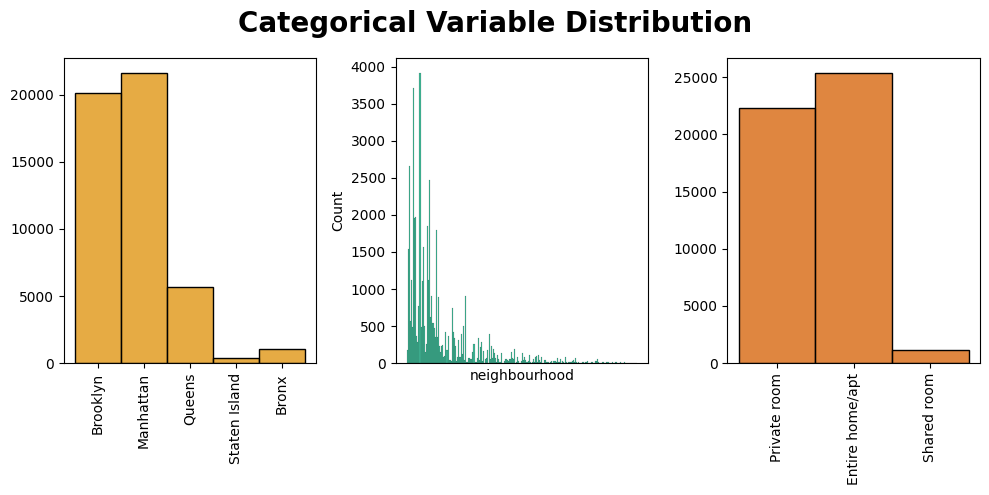

In [285]:
fig, axis = plt.subplots(1, 3, figsize=(10, 5))
fig.suptitle("Categorical Variable Distribution", fontweight='bold', fontsize=20)

# HISTOGRAM
sns.histplot(ax=axis[0], data=df_cat, x="neighbourhood_group", color=sns.color_palette("colorblind")[1]).set(xlabel=None, ylabel=None)
axis[0].set_xticklabels(axis[0].get_xticklabels(), rotation=90)

sns.histplot(ax=axis[1], data=df_cat, x="neighbourhood", color=sns.color_palette("colorblind")[2]).set_xticks([])

sns.histplot(ax=axis[2], data=df_cat, x="room_type", color=sns.color_palette("colorblind")[3]).set(xlabel=None, ylabel=None)
axis[2].set_xticklabels(axis[2].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()


Observations: 

- From 'neighbourhood_group' → Manhatan & Brooklyn are the top Airbnb rental locations.
- From 'room_type' → The majority of Airbnb listings are Entire Home/Apartments or Private Rooms, suggesting a focus on accomodating guests who prioritize privacy.

3.3. NUMERICAL VARIABLE ANALYSIS

In [286]:
df_num.head()

,host_id,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2787,149,1,9,0.21,6,365
1,2845,225,1,45,0.38,2,355
2,4632,150,3,0,0.00,1,365
3,4869,89,1,270,4.64,1,194
4,7192,80,10,9,0.10,1,0


In [287]:
df_num['minimum_nights'].mean()

np.float64(7.029962163820431)

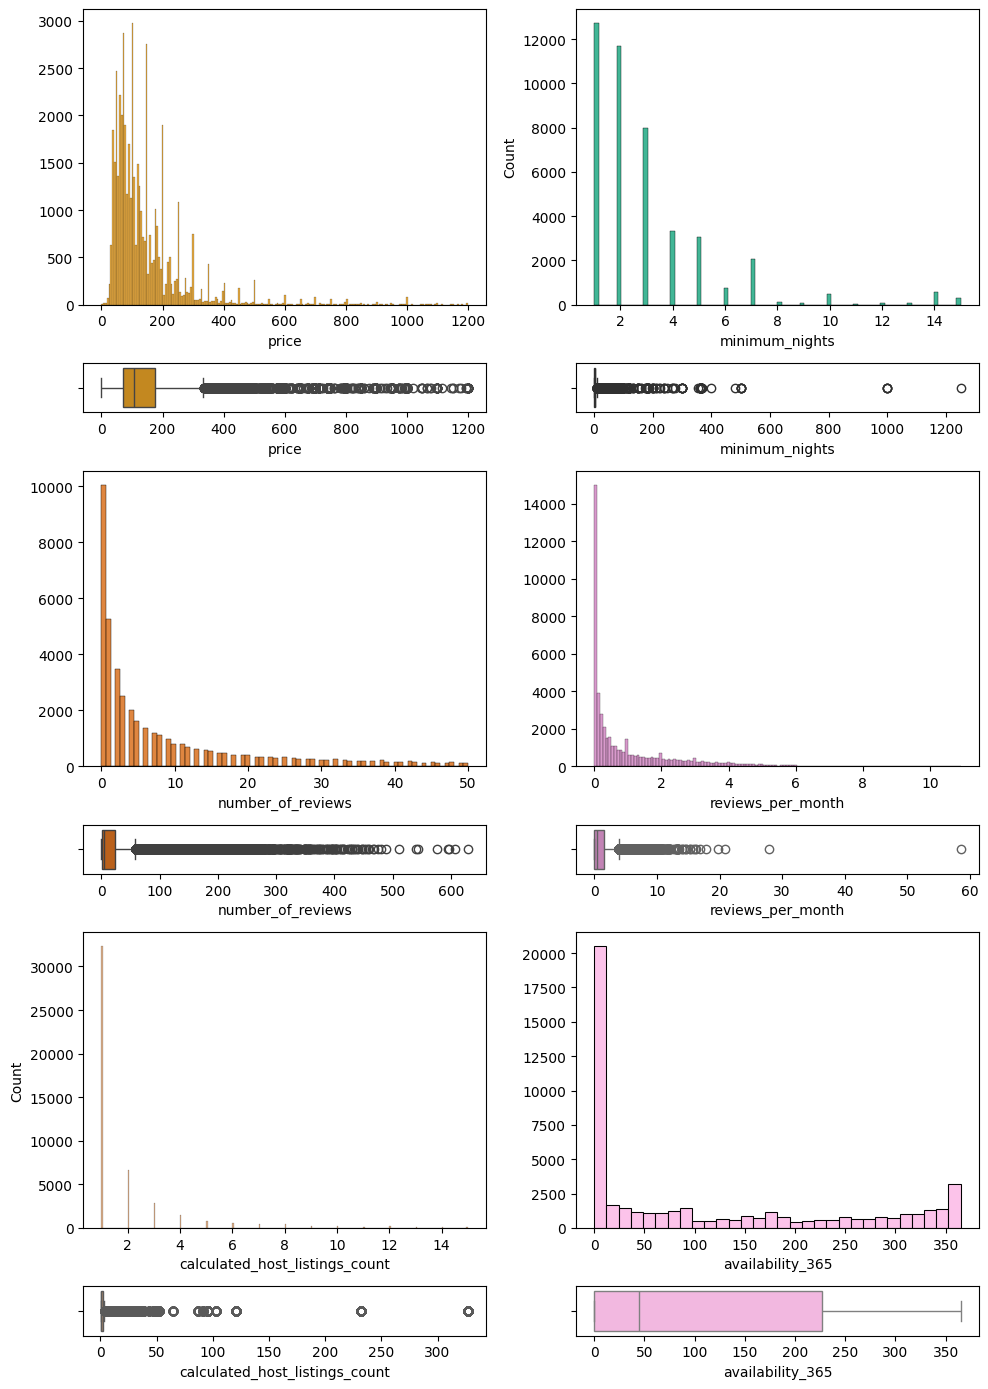

In [288]:
fig, ax = plt.subplots(6, 2, figsize = (10, 14), gridspec_kw = {"height_ratios": [6, 1, 6, 1, 6, 1]})

# 1sr row charts

sns.histplot(ax = ax[0,0], data = df_num[df_num['price']<1250], x='price', color=sns.color_palette("colorblind")[1]).set(ylabel = None)
sns.boxplot(ax = ax[1,0], data = df_num[df_num['price']<1250], x='price', color=sns.color_palette("colorblind")[1])

sns.histplot(ax = ax[0,1], data = df_num[df_num['minimum_nights']<16], x='minimum_nights', color=sns.color_palette("colorblind")[2])
sns.boxplot(ax = ax[1,1], data = df_num, x='minimum_nights', color=sns.color_palette("colorblind")[2])

# 2nd row charts

sns.histplot(ax = ax[2,0], data = df_num[df_num['number_of_reviews']<51], x='number_of_reviews', color=sns.color_palette("colorblind")[3]).set(ylabel = None)
sns.boxplot(ax = ax[3,0], data = df_num, x='number_of_reviews', color=sns.color_palette("colorblind")[3])

sns.histplot(ax = ax[2,1], data = df_num[df_num['reviews_per_month']<11], x='reviews_per_month', color=sns.color_palette("colorblind")[4]).set(ylabel = None)
sns.boxplot(ax = ax[3,1], data = df_num, x='reviews_per_month', color=sns.color_palette("colorblind")[4])

# 3rd row charts

sns.histplot(ax = ax[4,0], data = df_num[df_num['calculated_host_listings_count']<16], x='calculated_host_listings_count', color=sns.color_palette("colorblind")[5])
sns.boxplot(ax = ax[5,0], data = df_num, x='calculated_host_listings_count', color=sns.color_palette("colorblind")[5])

sns.histplot(ax = ax[4,1], data = df_num, x='availability_365', color=sns.color_palette("colorblind")[6]).set(ylabel = None)
sns.boxplot(ax = ax[5,1], data = df_num, x='availability_365', color=sns.color_palette("colorblind")[6])

plt.tight_layout()
plt.show()

4. MULTIVARIATE VARIABLE ANALYSIS

4.1. ENCODE CATEGORICAL VALUES AND SAVE JSON FILES

In [289]:
ng = list(df['neighbourhood_group'].unique())
neighbourhood_group_encoded = dict(zip(ng, list(range(len(ng)))))

with open('./enc/neighbourhood_group_encoded.json', 'w') as f:
    json.dump(neighbourhood_group_encoded, f)

In [290]:
n = list(df['neighbourhood'].unique())
neighbourhood_encoded = dict(zip(n, list(range(len(n)))))

with open('./enc/neighbourhood_encoded.json', 'w') as f:
    json.dump(neighbourhood_encoded, f)

In [291]:
rt = list(df['room_type'].unique())
room_type_encoded = dict(zip(rt, list(range(len(rt)))))

with open('./enc/room_type_encoded.json', 'w') as f:
    json.dump(room_type_encoded, f)

In [292]:
df_enc = df.copy()

In [293]:
df_enc['neighbourhood_group_encoded'] = df_enc['neighbourhood_group'].map(neighbourhood_group_encoded)
df_enc['neighbourhood_encoded'] = df_enc['neighbourhood'].map(neighbourhood_encoded)
df_enc['room_type_encoded'] = df_enc['room_type'].map(room_type_encoded)
df_enc.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type'], inplace=True)
df_enc.head()

,host_id,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_encoded,neighbourhood_encoded,room_type_encoded
0,2787,149,1,9,0.21,6,365,0,0,0
1,2845,225,1,45,0.38,2,355,1,1,1
2,4632,150,3,0,0.00,1,365,1,2,0
3,4869,89,1,270,4.64,1,194,0,3,1
4,7192,80,10,9,0.10,1,0,1,4,1


4.2. NUMERICAL-CATEGORICAL ANALYSIS (CORRELATION)

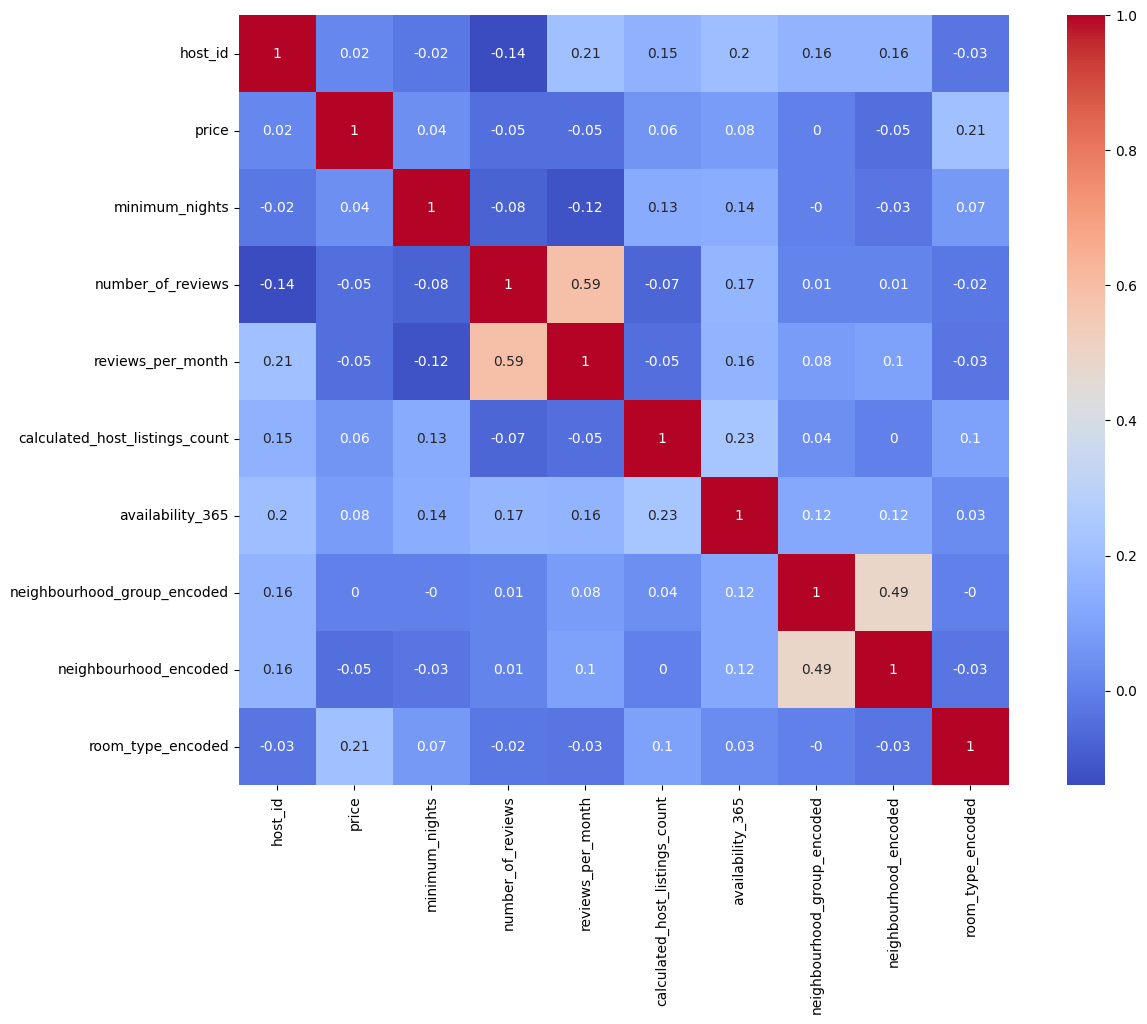

In [294]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_enc.corr().round(2), annot=True, cmap='coolwarm', square=True)

plt.show()

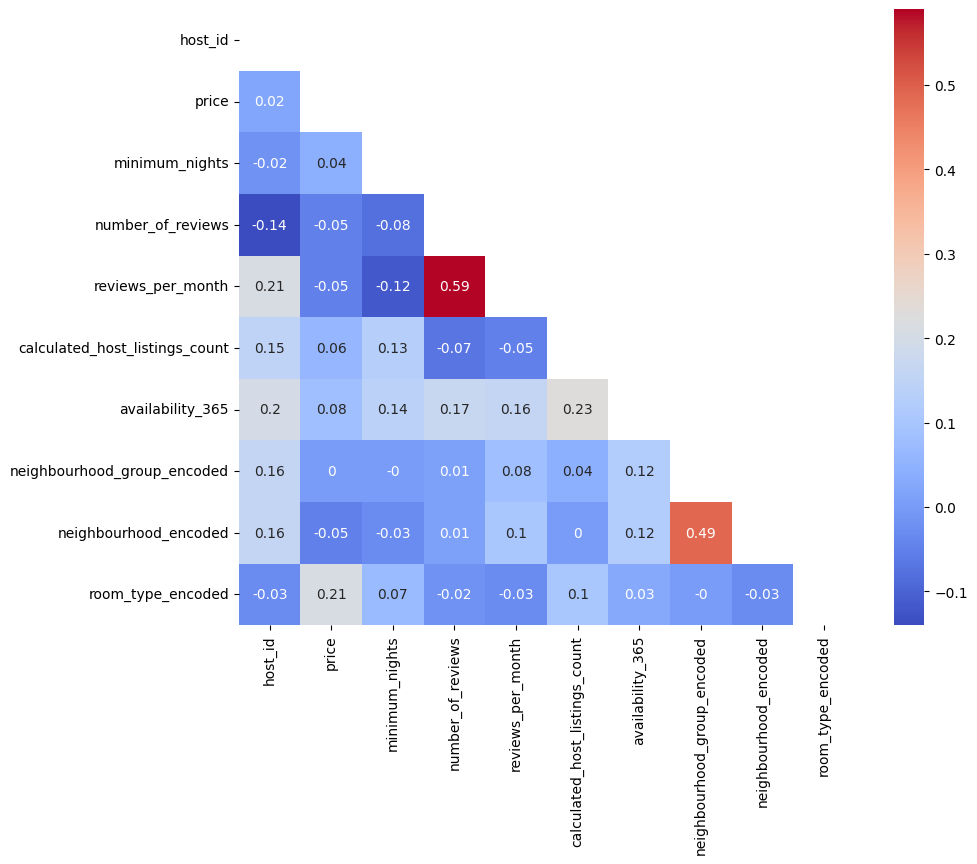

In [295]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_enc.corr().round(2), annot=True, mask=np.triu(df_enc.corr()), cmap='coolwarm', square=True)

plt.show()

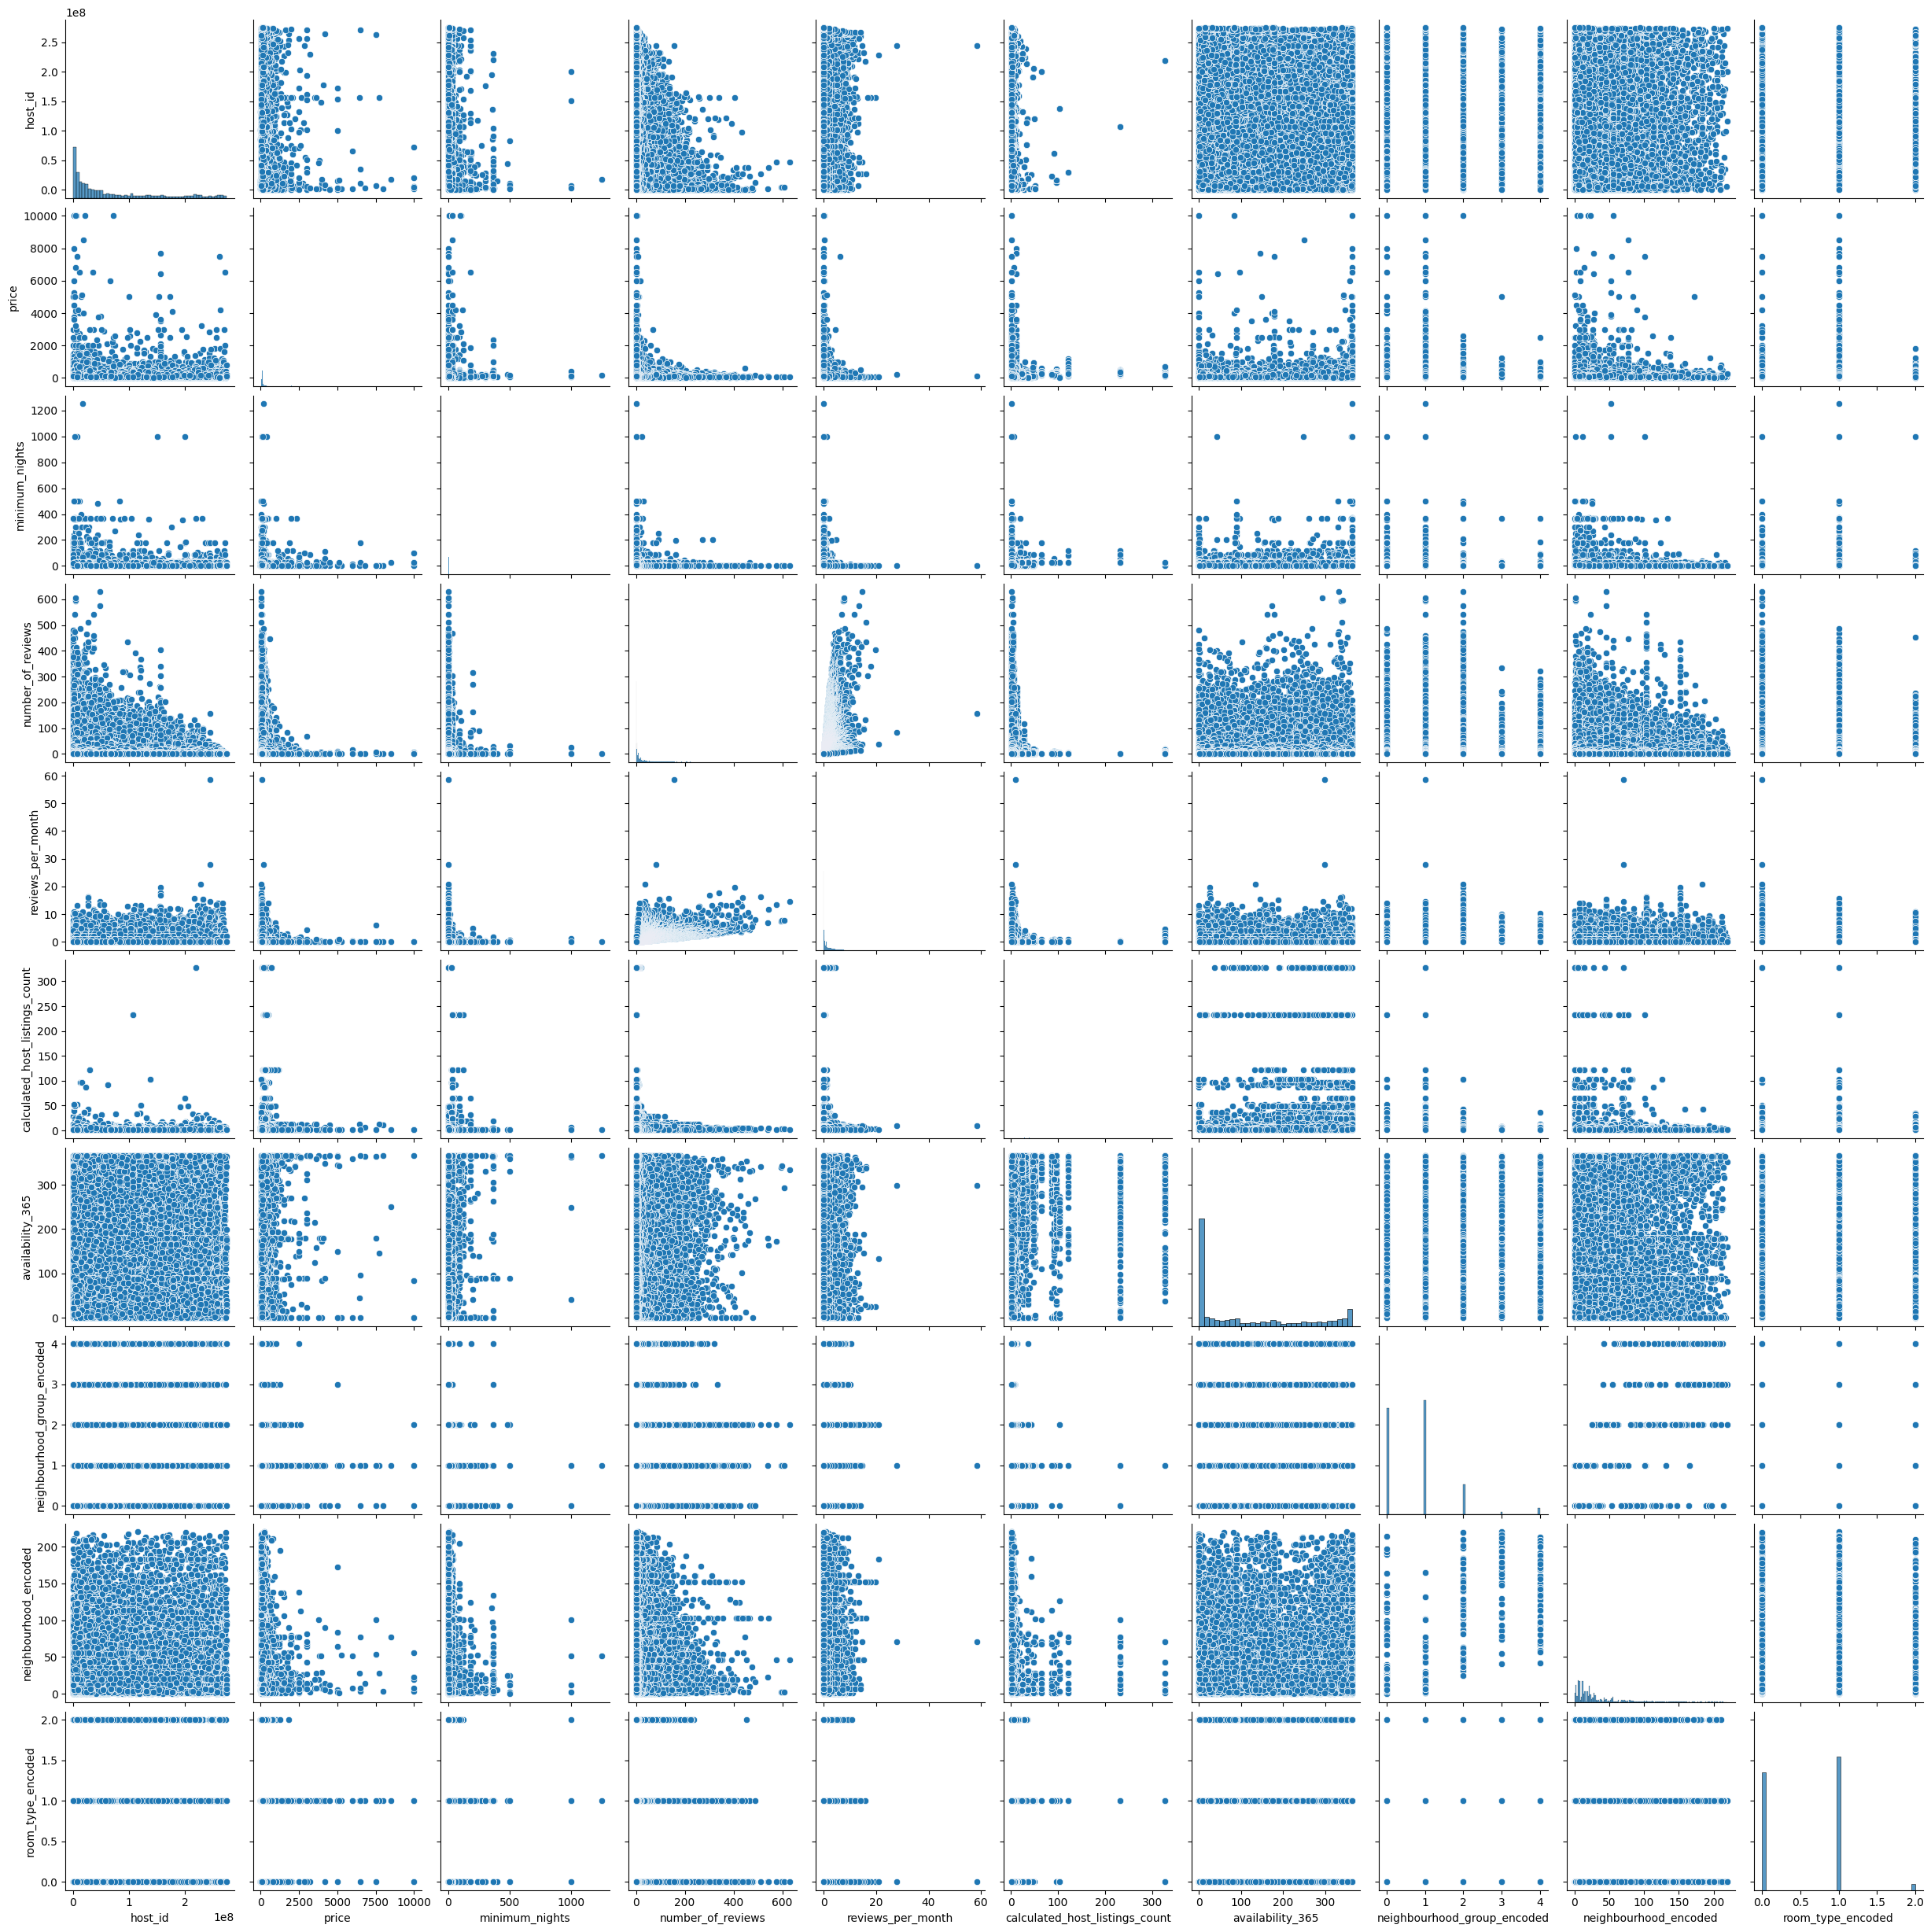

In [296]:
sns.pairplot(data=df_enc)
plt.show()

5. FEATURE ENGINEERING

5.1. OUTLIER ANALYSIS

In [297]:
df_enc.describe().round(2)

,host_id,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_encoded,neighbourhood_encoded,room_type_encoded
count,4.889500e+04,48895.00,48895.00,48895.00,48895.00,48895.00,48895.00,48895.00,48895.00,48895.00
mean,6.762001e+07,152.72,7.03,23.27,1.09,7.14,112.78,0.79,29.89,0.57
std,7.861097e+07,240.15,20.51,44.55,1.60,32.95,131.62,0.84,34.68,0.54
min,2.438000e+03,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
25%,7.822033e+06,69.00,1.00,1.00,0.04,1.00,0.00,0.00,7.50,0.00
50%,3.079382e+07,106.00,3.00,5.00,0.37,1.00,45.00,1.00,19.00,1.00
75%,1.074344e+08,175.00,5.00,24.00,1.58,2.00,227.00,1.00,37.00,1.00
max,2.743213e+08,10000.00,1250.00,629.00,58.50,327.00,365.00,4.00,220.00,2.00


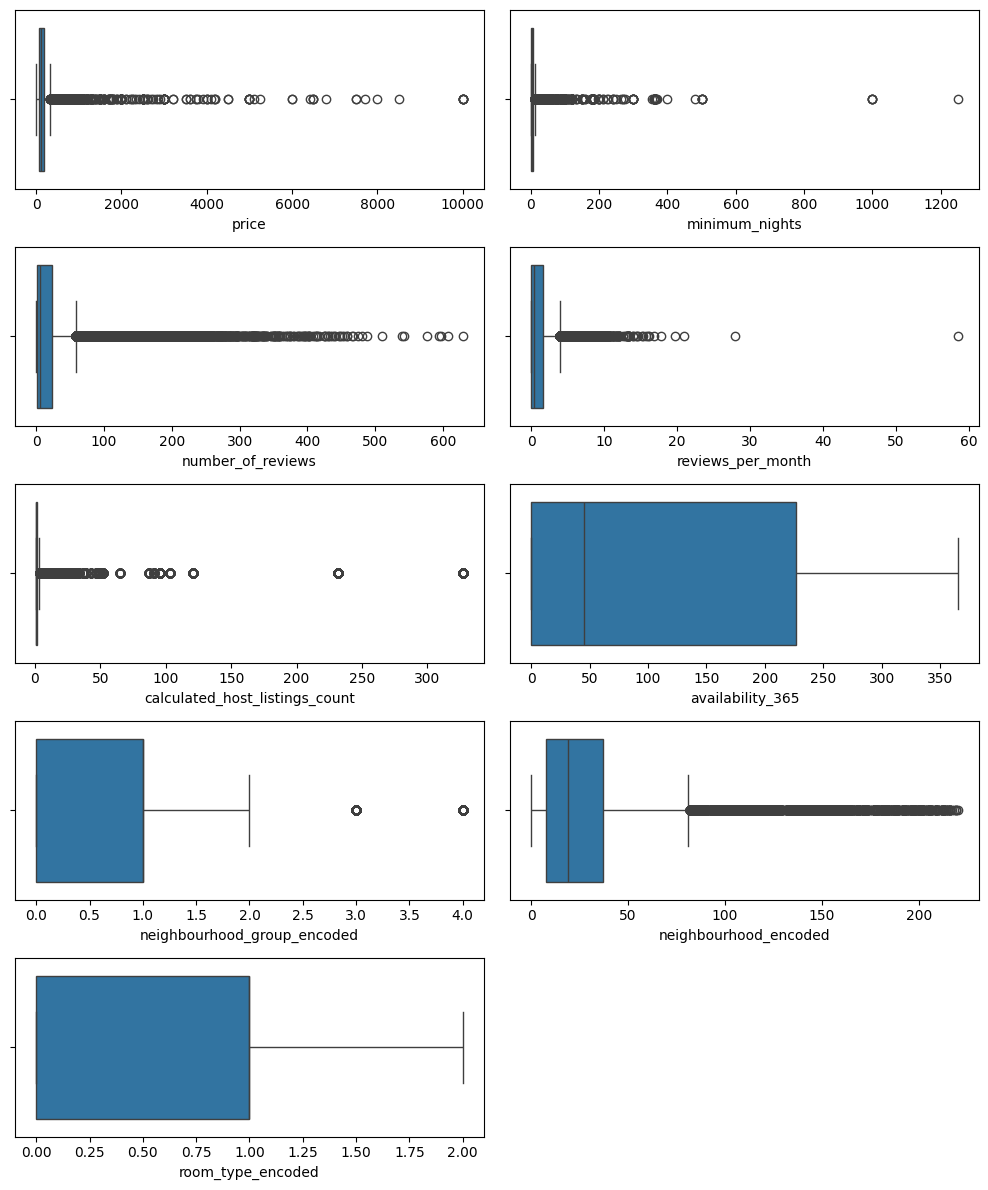

In [298]:
fig, ax = plt.subplots(5, 2, figsize = (10, 12))

sns.boxplot(ax = ax[0, 0], data = df_enc, x = "price")
sns.boxplot(ax = ax[0, 1], data = df_enc, x = "minimum_nights")

sns.boxplot(ax = ax[1, 0], data = df_enc, x = "number_of_reviews")
sns.boxplot(ax = ax[1, 1], data = df_enc, x = "reviews_per_month")

sns.boxplot(ax = ax[2, 0], data = df_enc, x = "calculated_host_listings_count")
sns.boxplot(ax = ax[2, 1], data = df_enc, x = "availability_365")

sns.boxplot(ax = ax[3, 0], data = df_enc, x = "neighbourhood_group_encoded")
sns.boxplot(ax = ax[3, 1], data = df_enc, x = "neighbourhood_encoded")

sns.boxplot(ax = ax[4, 0], data = df_enc, x = "room_type_encoded")
fig.delaxes(ax[4, 1])


plt.tight_layout()
plt.show()

In [299]:
df_enc_no = df_enc.copy()

In [300]:
# REMOVE OULTIERS
def remove_outliers(x, feature_name, allow_neg=True):
    Q1, Q3 = x.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    upper_lim = Q3 + (1.5*IQR)
    lower_lim = Q1 - (1.5*IQR) if allow_neg else max(0, Q1 - (IQR * 1.5))

    x = x.apply(lambda x: upper_lim if (x > upper_lim) else (lower_lim if (x < lower_lim) else x))

    filename = f'./enc/outliers_lims_{feature_name}.json'
    json.dump({'upper_lim': upper_lim, 'lower_lim': lower_lim}, open(filename, 'w'))

    return x

In [301]:
df_enc_no['price'] = remove_outliers(df_enc_no['price'], 'price')
df_enc_no['minimum_nights'] = remove_outliers(df_enc_no['minimum_nights'], 'minimum_nights')
df_enc_no['number_of_reviews'] = remove_outliers(df_enc_no['number_of_reviews'], 'number_of_reviews', allow_neg=False)
df_enc_no['reviews_per_month'] = remove_outliers(df_enc_no['reviews_per_month'], 'reviews_per_month', allow_neg=False)
df_enc_no['calculated_host_listings_count'] = remove_outliers(df_enc_no['calculated_host_listings_count'], 'calculated_host_listings_count')
df_enc_no['neighbourhood_group_encoded'] = remove_outliers(df_enc_no['neighbourhood_group_encoded'], 'neighbourhood_group_encoded')
df_enc_no['neighbourhood_encoded'] = remove_outliers(df_enc_no['neighbourhood_encoded'], 'neighbourhood_encoded')

5.2. MISSING VALUES

In [302]:
df_enc.isna().sum().sort_values(ascending=False) / len(df)

host_id                           0.0
price                             0.0
minimum_nights                    0.0
number_of_reviews                 0.0
reviews_per_month                 0.0
calculated_host_listings_count    0.0
availability_365                  0.0
neighbourhood_group_encoded       0.0
neighbourhood_encoded             0.0
room_type_encoded                 0.0
dtype: float64

5.3. SPLIT TRAIN/TEST FOR BOTH DFs 

In [303]:
def split(target, df, test_size=0.2, random_state=101):
    X = df.drop(columns=target)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [304]:
# SPLIT ORIGINAL DF
X_train_with_outliers, X_test_with_outliers, y_train, y_test = split('price', df_enc)
X_train_without_outliers, X_test_without_outliers, _, _ = split('price', df_enc_no)

y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

5.4. NORMALIZATION

In [305]:
def norm(X_train, X_test, reference: str):
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train_norm = scaler.transform(X_train)
    X_train_norm = pd.DataFrame(X_train_norm, index=X_train.index, columns=X_train.columns)

    X_test_norm = scaler.transform(X_test)
    X_test_norm = pd.DataFrame(X_test_norm, index=X_test.index, columns=X_test.columns)

    dump(scaler, open(f'./enc/normalized_{reference}.sav', 'wb'))

    return X_train_norm, X_test_norm

In [306]:
X_train_with_outliers_norm, X_test_with_outliers_norm = norm(X_train_with_outliers, X_test_with_outliers, 'with_outliers')
X_train_without_outliers_norm, X_test_without_outliers_norm = norm(X_train_without_outliers, X_test_without_outliers, 'without_outliers')

5.5. MIN.-MAX. SCALING

In [307]:
def minmax(X_train, X_test, reference: str):
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    
    X_train_minmax = scaler.transform(X_train)
    X_train_minmax = pd.DataFrame(X_train_minmax, index = X_train.index, columns=X_train.columns)

    X_test_minmax = scaler.transform(X_test)
    X_test_minmax = pd.DataFrame(X_test_minmax, index = X_test.index, columns=X_test.columns)
    
    dump(scaler, open(f'./enc/minmax_{reference}.sav', 'wb'))

    return X_train_minmax, X_test_minmax

In [308]:
X_train_with_outliers_minmax, X_test_with_outliers_minmax = minmax(X_train_with_outliers, X_test_with_outliers, 'with_outliers')
X_train_without_outliers_minmax, X_test_without_outliers_minmax = minmax(X_train_without_outliers, X_test_without_outliers, 'without_outliers')

6. FEATURE SELECTION

In [309]:
def kselection(X_train, X_test, y_train, k, reference: str):
    selection_model = SelectKBest(f_classif, k=k)
    selection_model.fit(X_train, y_train)
    cols = selection_model.get_support()

    X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns=X_train.columns.values[cols]) 
    X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns=X_test.columns.values[cols])

    dump(selection_model, open(f'./enc/selection_model_{reference}.sav', 'wb'))

    return X_train_sel, X_test_sel

In [310]:
X_train_with_outliers_sel, X_test_with_outliers_sel = kselection(X_train_with_outliers, X_test_with_outliers, y_train, 7, 'with_outliers')
X_train_without_outliers_sel, X_test_without_outliers_sel = kselection(X_train_without_outliers, X_test_without_outliers, y_train, 7, 'without_outliers')

6.1. APPLY FILTER TO NORMALIZED AND MIN-MAX SCALED DFs

In [311]:
X_train_with_outliers_norm_sel = X_train_with_outliers_norm[X_train_with_outliers_sel.columns]
X_train_without_outliers_norm_sel = X_train_without_outliers_norm[X_train_with_outliers_sel.columns]

X_test_with_outliers_norm_sel = X_test_with_outliers_norm[X_test_with_outliers_sel.columns]
X_test_without_outliers_norm_sel = X_test_without_outliers_norm[X_test_with_outliers_sel.columns]

X_train_with_outliers_minmax_sel = X_train_with_outliers_minmax[X_train_with_outliers_sel.columns]
X_train_without_outliers_minmax_sel = X_train_without_outliers_minmax[X_train_without_outliers_sel.columns]

X_test_with_outliers_minmax_sel = X_test_with_outliers_minmax[X_test_with_outliers_sel.columns]
X_test_without_outliers_minmax_sel = X_test_without_outliers_minmax[X_test_without_outliers_sel.columns]

6.2. SAVE CSV FILES

In [312]:
dfs_train = [X_train_with_outliers_sel, X_train_without_outliers_sel, 
             X_train_with_outliers_norm_sel, X_train_without_outliers_norm_sel, 
             X_train_with_outliers_minmax_sel, X_train_without_outliers_minmax_sel]

dfs_test = [X_test_with_outliers_sel, X_test_without_outliers_sel, 
            X_test_with_outliers_norm_sel, X_test_without_outliers_norm_sel, 
            X_test_with_outliers_minmax_sel, X_test_without_outliers_minmax_sel]

In [313]:
# TRAIN DFs
X_train_with_outliers_sel.to_csv('../data/processed/X_train_with_outliers_sel.csv', index=False)
X_train_without_outliers_sel.to_csv('../data/processed/X_train_without_outliers_sel.csv', index=False)
X_train_with_outliers_norm_sel.to_csv('../data/processed/X_train_with_outliers_norm_sel.csv', index=False)
X_train_without_outliers_norm_sel.to_csv('../data/processed/X_train_without_outliers_norm_sel.csv', index=False)
X_train_with_outliers_minmax_sel.to_csv('../data/processed/X_train_with_outliers_minmax_sel.csv', index=False)
X_train_without_outliers_minmax_sel.to_csv('../data/processed/X_train_without_outliers_minmax_sel.csv', index=False)

# TEST DFs
X_test_with_outliers_sel.to_csv('../data/processed/X_test_with_outliers_sel.csv', index=False)
X_test_without_outliers_sel.to_csv('../data/processed/X_test_without_outliers_sel.csv', index=False)
X_test_with_outliers_norm_sel.to_csv('../data/processed/X_test_with_outliers_norm_sel.csv', index=False)
X_test_without_outliers_norm_sel.to_csv('../data/processed/X_test_without_outliers_norm_sel.csv', index=False)
X_test_with_outliers_minmax_sel.to_csv('../data/processed/X_test_with_outliers_minmax_sel.csv', index=False)
X_test_without_outliers_minmax_sel.to_csv('../data/processed/X_test_without_outliers_minmax_sel.csv', index=False)